In [1]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8 MB 18 kB/s 
     |████████████████████████████████| 50 kB 2.2 MB/s 
     |████████████████████████████████| 3.8 MB 26.4 MB/s 
     |████████████████████████████████| 448 kB 35.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=6d39222970e368e34cdfc93a87f46caa086b20b18accc1c6c2d2b5faa56e63e7
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.1.0
Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive

/content/drive/MyDrive



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         

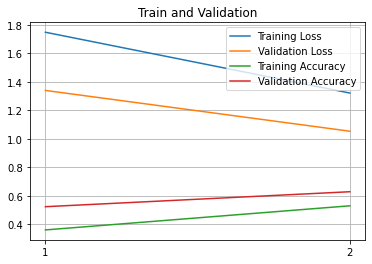


Test:
              precision    recall  f1-score   support

    airplane     0.7386    0.6500    0.6915      1000
  automobile     0.6744    0.8450    0.7501      1000
        bird     0.5505    0.5070    0.5279      1000
         cat     0.4116    0.5330    0.4645      1000
        deer     0.6145    0.4750    0.5358      1000
         dog     0.5008    0.6080    0.5492      1000
        frog     0.8445    0.5540    0.6691      1000
       horse     0.5905    0.7700    0.6684      1000
        ship     0.8171    0.6970    0.7523      1000
       truck     0.7591    0.6460    0.6980      1000

    accuracy                         0.6285     10000
   macro avg     0.6502    0.6285    0.6307     10000
weighted avg     0.6502    0.6285    0.6307     10000



In [5]:
import ssl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report

# epochs num
epochs = 50

# number of times the train is done
repetitions = 10

# path to model to save
model_path = './vgg.h5'

# define which dataset to use
def dataset():
    ssl._create_default_https_context = ssl._create_unverified_context

    # loading the dataset
    (x_train,y_train),(x_test,y_test)=cifar10.load_data()

    # setting class names
    class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

    # normalize the test data
    x_test=x_test/255.0
    
    # creating dataset object
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = (
        train_ds
        .shuffle(1024)
        .map(scale)
        .map(augment)
        .batch(128)
    )

    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    test_ds = (
        test_ds
        .batch(128)
    )

    return train_ds, test_ds, y_test, class_names

# define model
def _model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # define callbacks
    train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    )
    ]

    return model, train_callbacks

# utility to plot training and validation history
def plot_history(history):
    x_epochs = []
    for i in range(0,len(history.history["accuracy"])):
        x_epochs.append(i+1)	
    fig = plt.figure()
    plt.title('Train and Validation')
    x = list(range(0, len(history.history["accuracy"]), 1))
    plt.xticks(x, x_epochs)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()
    return fig

# scale image
def scale(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

# data augmentation
def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    return image, label

model, train_callbacks = _model()
print()
model.summary()
best_acc = -1.0
for i in range (0, repetitions):
    train_ds, test_ds, y_test, class_names = dataset()
    model, train_callbacks = _model()
    print("\nTrain " + str(i + 1) + ":")
    print("\nTrain and Validation:")
    history = model.fit(train_ds,
                      epochs=epochs,
                      callbacks=train_callbacks,
                      validation_data=test_ds)
    test_loss, test_accuracy = model.evaluate(test_ds)
    if (test_accuracy > best_acc):
        best_acc = test_accuracy
        best_model = model
        best_history = history
fig = plot_history(best_history)
fig.savefig("./Train and Validation.png")
best_model.save(model_path)
print("\nTest:")
y_prob = best_model.predict(test_ds)
y_pred = [np.argmax(x) for x in y_prob]
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
